# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
from astropy import units as uu
region_name = "MDIS_10-800" #"TDS" #  _ELAISN1
simbad_query = False
query_radius = 2 * uu.arcsec
match_radius = 1 * uu.arcsec

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import unique, Table, hstack, join, setdiff
import numpy as np
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.tables import TableCollection, dd_vasca_columns
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, get_col_cycler
from astroquery.simbad import Simbad
from itertools import cycle
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
import numpy.ma as ma
#import matplotlib as mpl
from cycler import cycler

#prepare file names
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
assocs_fname = "./vasca_pipeline/"+region_name+"/assocs_"+region_name+".fits"

# Get region and source coordinates
rg = Region()
rg.load_from_fits(region_fname)
#rg.set_hardness_ratio()
sel_src = rg.tt_sources["sel"]
tt_src = rg.tt_sources[sel_src]
display(tt_src[0:2])

# Add object group ID
def add_ogrp(tc,tt_name):
    "Helper funtion to add ogrp:id column to tables"
    tt = tc.__dict__[tt_name]
    tc.add_column(tt_name,"ogrp")
    has_mask = ma.is_masked(tt["otype"].data)
    for ii in range(len(tt)):
        if has_mask and tt["otype"].mask[ii]:
            tt["otype"][ii]="none"
            tt["otype"].mask[ii] = False
        tt["ogrp"][ii] = otype2ogroup(tt["otype"][ii])

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,assoc_ffactor,assoc_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32
-1,175 .. 98,150.1949174665478,2.067917488917891,0.041145824,-0.33278635,0.15272313,1.0,0.30049813,1149,0.063385345,1 .. 2,True,13.825647 .. 8.437315,0.08337321 .. 0.10609022,0.009582018 .. 0.011795453,3.6751015 .. 2.2731214,1.1984851e-35 .. 1.03325244e-10,2.96802 .. 2.1985245,0.9611866 .. 1.0157672,-4.8286705 .. 0.9930416,-1,25,10,0.60487556,0.009556857
-1,147 .. 130,150.179954836128,2.1103311508629656,0.041988235,-0.28247258,0.24774879,1.0,0.47760198,90,0.04686192,1 .. 2,True,17.842085 .. 6.3060455,0.109606236 .. 0.08087121,0.0074414667 .. 0.005808099,4.9870253 .. 1.288465,1.2902245e-17 .. 0.15441209,2.334232 .. 1.1265781,0.9595368 .. 0.9832187,-5.593553 .. -1.0534607,-1,30,10,0.34160548,0.006894858


### Query the SIMBAD data or read from file

In [3]:
# Get matches
mt = TableCollection()
if simbad_query:
    print("Query to SIMBAD ...")
    # Run query
    src_coord = SkyCoord(tt_src["ra"].quantity,tt_src["dec"].quantity,frame='icrs')
    customSimbad = Simbad()
    customSimbad.TIMEOUT = 180
    vo_entries = ['otype',"otype(opt)","otypes", 'distance', "distance_result","velocity","z_value"]   # ,"propermotions"
    customSimbad.add_votable_fields(*vo_entries)
    tt_simbad = customSimbad.query_region(src_coord,radius=query_radius)
    
    # Change type to be handabel by astropy
    vo_change_type = ["MAIN_ID","COO_BIBCODE","OTYPE","OTYPE_opt","OTYPES", "RVZ_BIBCODE"]  # "PM_BIBCODE"
    for vo in vo_change_type:
        tt_simbad[vo] = tt_simbad[vo].data.astype("S32")

    # Write simbad and source info into matching tables
    src_idx = tt_simbad["SCRIPT_NUMBER_ID"]-1
    tt_simbad["rg_src_id"] = tt_src[src_idx]["rg_src_id"]
    tt_simbad["match_id"] = np.array(range(0,len(tt_simbad)), dtype= np.int32)
    tt_simbad.rename_column('OTYPE_opt', 'otype')
else:
    tt_simbad = Table.read(assocs_fname, hdu="tt_simbad")
tt_simbad.sort(['rg_src_id', 'DISTANCE_RESULT'])
mt.add_table(tt_simbad,"tt_simbad")
display(mt.tt_simbad[:2])

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,otype,OTYPES,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,DISTANCE_RESULT,RVZ_TYPE,RVZ_RADVEL,RVZ_ERROR,RVZ_QUAL,RVZ_WAVELENGTH,RVZ_BIBCODE,Z_VALUE,SCRIPT_NUMBER_ID,rg_src_id,match_id
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,,,,,,,arcsec,,km / s,km / s,,,,,,,
bytes32,bytes13,bytes13,int16,int16,float32,float32,int16,bytes1,bytes1,bytes32,bytes32,bytes32,bytes32,float64,bytes1,bytes4,float64,float64,bytes8,bytes19,float32,bytes1,float64,float32,bytes1,bytes1,bytes32,float64,int32,int32,int32
2XMM J100046.7+020404,10 00 46.7335,+02 04 04.463,14,14,2.287,3.314,90,C,O,2020yCat.1350....0G,Seyfert1,Sy1,Sy1|AGN|AGN|AGN|AGN|AGN|*|AG?|G|,--,,,--,--,,,0.7003,z,0.552,0.000,C,O,2009ApJ...696.1195T,0.5524000,1,25,0
[AFH2012] 110,10 00 43.1496,+02 06 37.332,8,8,--,--,0,D,X,2012ApJ...758...47A,GroupG,GrG,GrG|GrG|X,--,,,--,--,,,0.6092,z,0.361,--,D,O,2012ApJ...758...47A,0.3610000,2,30,1


### Create matching table

In [4]:
# Create simbad table with best match on top
# Take the closest match
mt_sim_cols = ["rg_src_id","otype","MAIN_ID","OTYPES","Z_VALUE","Distance_distance","Distance_unit","DISTANCE_RESULT"]
tt_simbad_grp =  mt.tt_simbad.group_by('rg_src_id')
mult_match = 0
for key, tt_grp in zip(tt_simbad_grp.groups.keys, tt_simbad_grp.groups):
    sel_dist = tt_grp['DISTANCE_RESULT']< match_radius
    if sel_dist.sum()>1:
        mult_match += 1
print(f"Nr of sources with several possible associations within matching radius: {mult_match} / {len(tt_simbad_grp.groups.keys)} / {len(tt_src)} / {len(rg.tt_sources)}")
tu_simbad = unique(tt_simbad_grp, keys="rg_src_id")

Nr of sources with several possible associations within matching radius: 63 / 3099 / 4612 / 573356


In [5]:
mt_vas_cols = ["rg_src_id","pos_err","ra","dec","obs_filter_id","flux","flux_err","flux_nxv","hr","hr_err","nr_det", "sel"]
tt_match = join(tu_simbad[mt_sim_cols], tt_src[mt_vas_cols], keys='rg_src_id',join_type='outer')

#Select only sources with countrparts within a given radius
sel_query = ~tt_match['DISTANCE_RESULT'].mask
tt_match["sel"] = sel_query
tt_match["sel"][tt_match["sel"]] = tt_match['DISTANCE_RESULT'][tt_match["sel"]]< match_radius
sel_mt = tt_match["sel"]

#Add tables to table collection
mt.add_table(tt_match,"tt_match")

# Add object group
add_ogrp(mt,"tt_match")

display(mt.tt_match)
#Write and show
mt.write_to_fits(assocs_fname)


rg_src_id,otype,MAIN_ID,OTYPES,Z_VALUE,Distance_distance,Distance_unit,DISTANCE_RESULT,pos_err,ra,dec,obs_filter_id,flux,flux_err,flux_nxv,hr,hr_err,nr_det,sel,ogrp
,,,,,,,arcsec,arcsec,deg,deg,,1e-06 Jy,1e-06 Jy,,,,,,
int32,bytes32,bytes32,bytes32,float64,float64,bytes4,float32,float32,float64,float64,int32[2],float32[2],float32[2],float32[2],float32,float32,int32[2],bool,bytes8
25,Sy1,2XMM J100046.7+020404,Sy1|AGN|AGN|AGN|AGN|AGN|*|AG?|G|,0.5524000,--,,0.7003,0.041145824,150.1949174665478,2.067917488917891,1 .. 2,13.825647 .. 8.437315,0.08337321 .. 0.10609022,0.009582018 .. 0.011795453,0.60487556,0.009556857,175 .. 98,True,AGN
30,GrG,[AFH2012] 110,GrG|GrG|X,0.3610000,--,,0.6092,0.041988235,150.179954836128,2.1103311508629656,1 .. 2,17.842085 .. 6.3060455,0.109606236 .. 0.08087121,0.0074414667 .. 0.005808099,0.34160548,0.006894858,147 .. 130,True,GAL
46,QSO,[VV2006] J100034.9+020235,QSO|AGN|QSO|AGN|AGN|AGN|AGN|AGN|,1.1767000,--,,0.6199,0.048536114,150.1457598609391,2.0430761139418454,1 .. 2,9.627526 .. 3.548064,0.08036308 .. 0.08531286,0.027183572 .. 0.013845152,0.35354573,0.012043198,159 .. 68,True,AGN
129,G,zCOSMOS 830948,G|G|G|G,0.1217700,--,,0.6634,0.1531103,150.25768134959156,2.4299764640418453,1 .. 2,3.8677037 .. 2.8708813,0.1942638 .. 0.14234988,1.6588343 .. 0.021389613,1.5808098,0.45111918,17 .. 19,True,GAL
140,G,zCOSMOS 824730,G,0.0408000,--,,1.3309,0.0964043,150.12560488462506,2.1497289589183195,1 .. 2,12.134099 .. 5.3306375,0.62383395 .. 0.095689245,0.08772719 .. 0.0044168155,1.0313463,0.3487316,7 .. 85,False,GAL
168,QSO,[VV2006] J142015.6+523718,QSO|QSO|QSO|QSO|QSO|AGN|*|Opt|UV,1.6710000,--,,0.2442,0.04258191,215.06529867170275,52.62191634479352,1 .. 2,25.120228 .. 10.190636,0.09629602 .. 0.1344548,0.017485289 .. 0.0069791414,0.3808469,0.0068977145,162 .. 63,True,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566353,RR*,DES J003201.93-442110.9,RR*|RR*|*|RR?|RR?,--,--,,0.2086,0.086085595,8.007987127882856,-44.353016488427016,1 .. 0,26.447018 .. -1.0,0.19983563 .. -1.0,0.26761478 .. -100.0,-1.0,-1.0,45 .. -1,True,Star


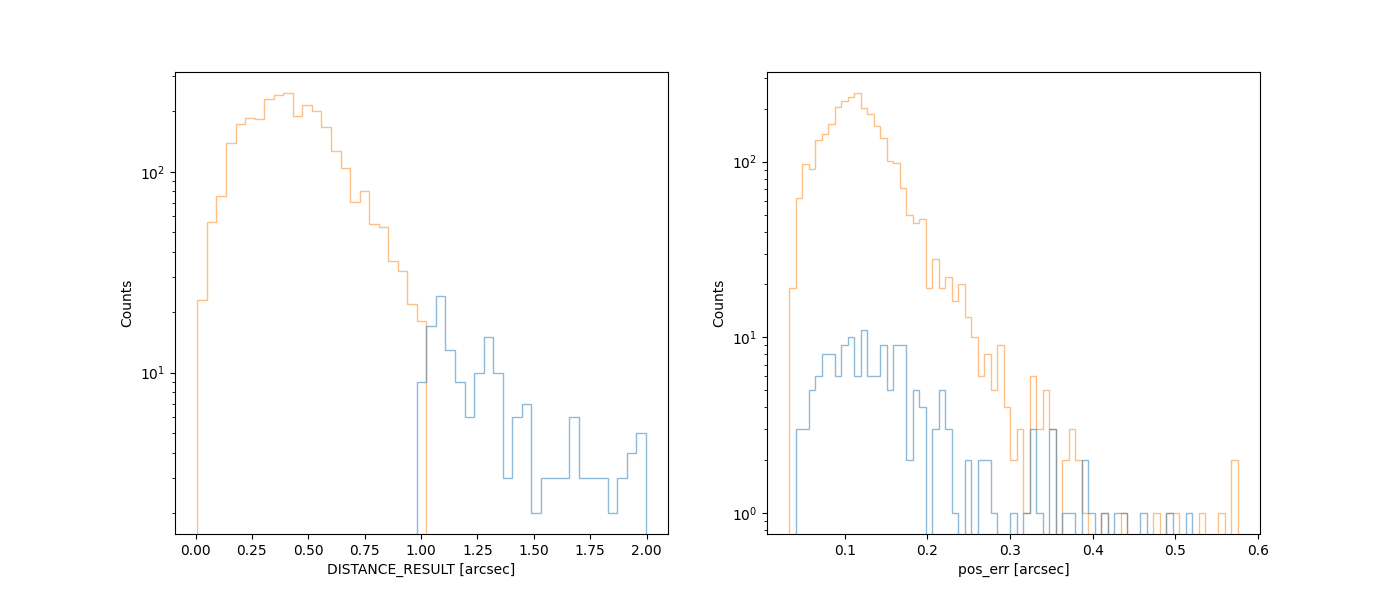

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs = np.array(axs).flatten()
_ = vvis.plot_table_hist(mt.tt_match[sel_query], 'DISTANCE_RESULT', ax=axs[0], logx=False, obs_filter_id=None, density= False)
_ = vvis.plot_table_hist(mt.tt_match[sel_query], 'pos_err', ax=axs[1], logx=False, obs_filter_id=None, density= False)

### Plot found object types

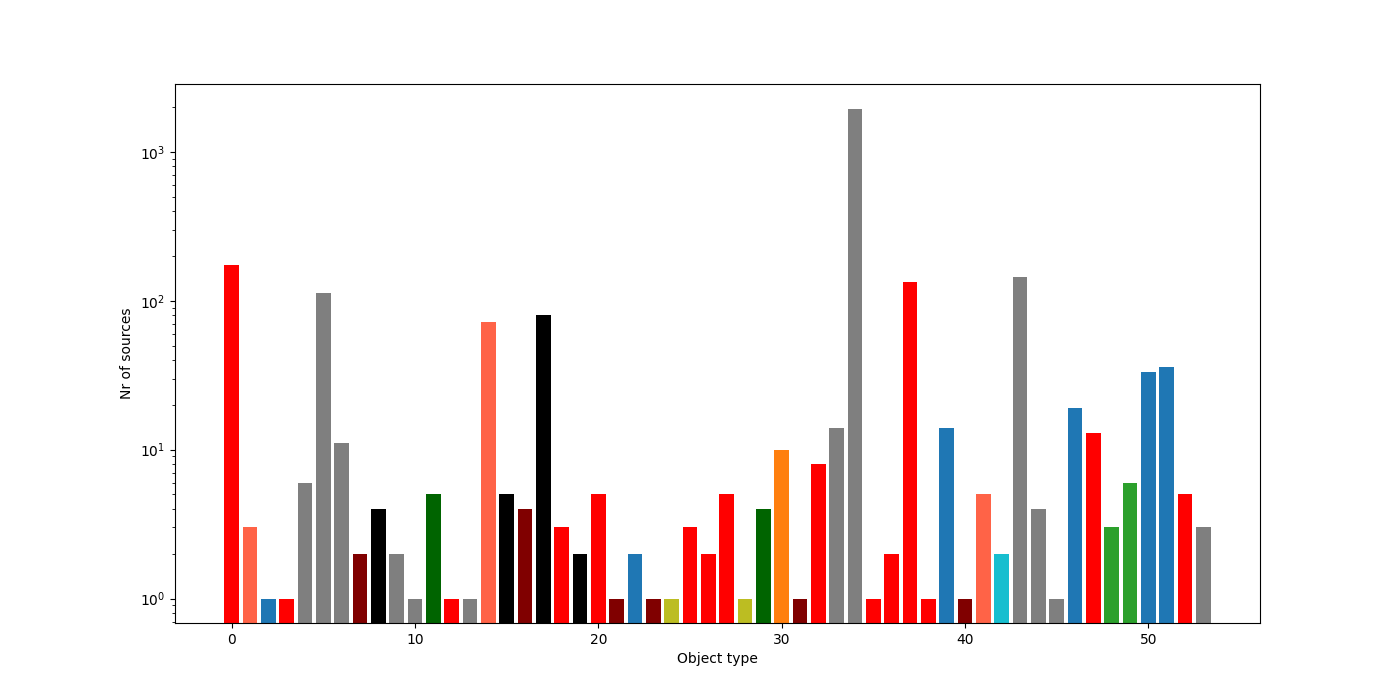

otype Candidate             Description             ogrp     Label                       Category                                          Subcategory                         
                                                                                                                                                                               
----- --------- ----------------------------------- ---- ------------- ------------------------------------------- ------------------------------------------------------------
    ?        --            Object of Unknown Nature  UNK       Unknown 8. BLENDS, ERRORS, NOT WELL DEFINED OBJECTS                                                           --
    *        --                                Star Star          Star                        1. TAXONOMY OF STARS                                                           --
   **       **?             Double or Multiple Star   B*            **                        1. TAXONOMY OF STARS  Inte

In [7]:
fig_otypes = plt.figure("Source types",figsize=(14, 7))
fig_otypes.clf()

otypes_all, otype_cts_all= np.unique(mt.tt_match[sel_mt]["otype"],return_counts=True)
dd_otype2id = dict(zip(list(otypes_all),range(len(otypes_all))))

tt_mt_grp =  mt.tt_match[sel_mt].group_by("ogrp")
for group, tt_grp in zip(tt_mt_grp.groups.keys, tt_mt_grp.groups):
    otypes, otype_cts= np.unique(tt_grp["otype"],return_counts=True)
    otypes_id = []
    for otype in otypes:
        otypes_id.append(dd_otype2id[otype])
    plt.bar( otypes_id, otype_cts, align='center', label=group[0], color = dd_ogrp2col[group[0]])
plt.yscale('log')
#plt.grid()
plt.xlabel("Object type")
plt.ylabel("Nr of sources")
plt.show()
plt.legend()
plt.xticks(range(len(otypes_all)), otypes_all, size='small')


tt_nodes = Table.read('./resources/SIMBAD_otypes/otypes_nodes.csv') #, format='ascii.daophot'
ids, ids_idx, _ = np.intersect1d(tt_nodes["Id"],np.array(otypes_all),return_indices=True)
candidate = np.asarray(np.ma.masked_array(data = tt_nodes["Candidate"],mask = False, fill_value = "none"))
can, can_idx, _ = np.intersect1d(candidate,np.array(otypes),return_indices=True)
all_idx = np.unique(np.append(ids_idx,can_idx))
tt_nodes.rename_column('Id', 'otype')
mt.add_table(tt_nodes[all_idx],"tt_otypes")
add_ogrp(mt,"tt_otypes")
mt.tt_otypes["otype","Candidate","Description","ogrp","Label","Category","Subcategory"].pprint_all()#show_dtype=True #,"Status","Priority"
mt.write_to_fits(assocs_fname)

### Scatter plots of source variables by group

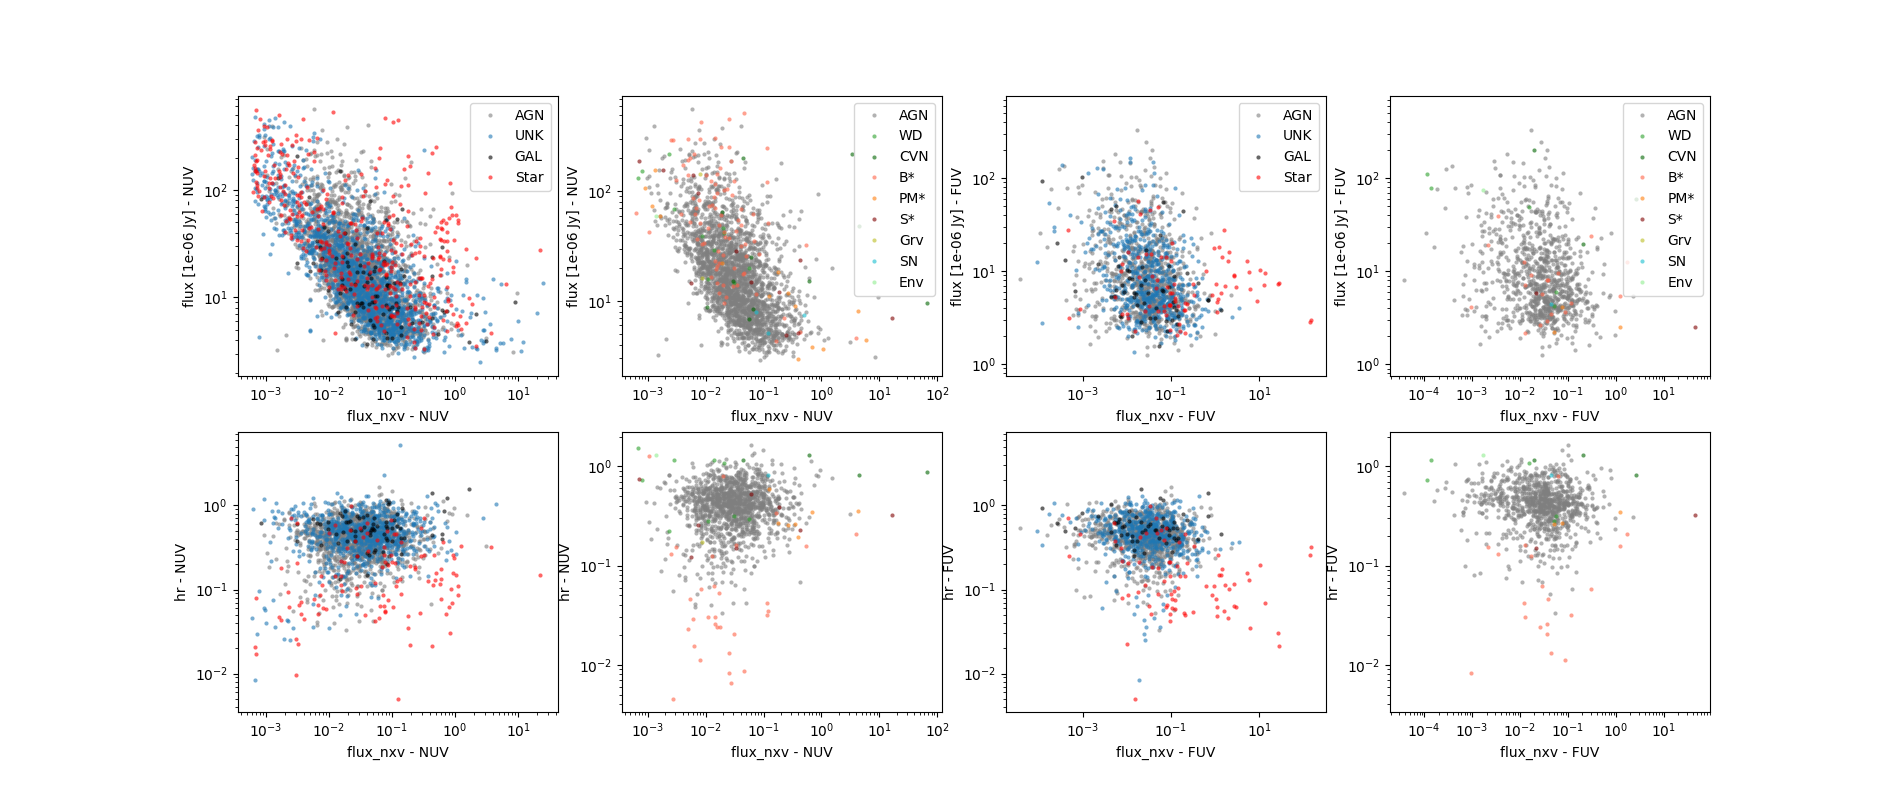

In [8]:
plot_kwargs = {"markersize": 3.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
#fig.clf()
axs = axs.flatten()
plt_ogrops = [["AGN","UNK","GAL",'Star'],["AGN",'WD', 'CVN', 'B*', 'PM*',"S*", 'Grv', 'SN',"Env"]]

plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        #axs[ctr].cla()
        axs[ctr].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(mt.tt_match,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)

        #axs[ctr+4].cla()
        axs[ctr+4].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(mt.tt_match,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)
        ctr +=1

_ = axs[0].legend()
_ = axs[1].legend()
_ = axs[2].legend()
_ = axs[3].legend()
#print(dd_ogrp2otypes.keys())r

### Print info for selected sources

In [9]:
# Make selection
sel_otype = mt.tt_match["otype"] ==  "RR*"# "No*"#"HS?" #"BS*" #"PM*" # # "SN*" #"EB*"
sel_otypes = (mt.tt_match["otype"] ==  "WD?")  + (mt.tt_match["otype"] =="WD*")
sel_flux_nxv = mt.tt_match["flux_nxv"][:,0]>2
sel_flux_hr = mt.tt_match["hr"]>2
sel_src_id = mt.tt_match["rg_src_id"]==15179
sel_srcs =  sel_otypes  #sel_src_id  #sel_flux_nxv #sel_otype # sel_flux_nxv_fuv # sel_flux_hr#

#Display match and simbad table for selected sources
display(mt.tt_match[sel_srcs])

#Print oout list of source IDs to be used for further use, e.g. in inspect_sources.ipynb
print("srcs_ids = [", end="")
for src_id in mt.tt_match[sel_srcs]["rg_src_id"].data:
    print(src_id,",", end="")
print("]")

rg_src_id,otype,MAIN_ID,OTYPES,Z_VALUE,Distance_distance,Distance_unit,DISTANCE_RESULT,pos_err,ra,dec,obs_filter_id,flux,flux_err,flux_nxv,hr,hr_err,nr_det,sel,ogrp
,,,,,,,arcsec,arcsec,deg,deg,,1e-06 Jy,1e-06 Jy,,,,,,
int32,bytes32,bytes32,bytes32,float64,float64,bytes4,float32,float32,float64,float64,int32[2],float32[2],float32[2],float32[2],float32,float32,int32[2],bool,bytes8
900,WD*,SDSS J142118.18+523547.1,WD*|WD*|blu|WD*|*|Opt|WD?,0.0000500,311.0400,pc,0.5117,0.061777495,215.3258439968967,52.596545351520945,1 .. 2,69.76633 .. 78.84212,0.2989939 .. 0.35905793,0.0028636206 .. 0.00013604689,1.1639541,0.017203152,35 .. 55,True,WD
11630,WD*,GALEX J095902.8+013847,WD*|WD*|WD*|PM*|WD*|WD*|*|*|G|Op,0.0001800,194.9580,pc,0.7095,0.050711945,149.76167436162893,1.6465905160899403,1 .. 2,154.65216 .. 112.11728,0.3336962 .. 0.5372641,0.00080672395 .. 0.00011547043,0.72394663,0.005090711,67 .. 46,True,WD
52486,WD?,[LKK2008] J221458.39-180742.6,*|WD?|WD?|WD?,--,--,,0.2090,0.07469829,333.74330229428716,-18.1284418039241,1 .. 2,15.743377 .. 4.2345347,0.17000161 .. 0.11394305,0.01079712 .. 0.052266393,0.2847042,0.013879122,62 .. 41,True,WD
53151,WD*,GALEX J221409.8+005245,WD*|WD*|WD*|*|Opt|UV,--,439.0000,pc,0.2767,0.106176615,333.54135905569626,0.8794295342456827,1 .. 2,20.118876 .. 4.6691704,0.19772485 .. 0.3908768,0.056504067 .. -0.026277466,0.29695582,0.026712412,32 .. 4,True,WD
58506,WD?,ZTF J172400.04+604451.8,EB*|*|WD?|WD?,--,--,,0.2700,0.09249079,261.0003596219375,60.747724074915844,1 .. 2,42.035763 .. 49.616528,0.2805657 .. 0.656898,0.020497339 .. 0.0150321275,1.0894871,0.017481763,25 .. 12,True,WD
72801,WD?,GALEX J161634.4+541011,*|*|Opt|UV|WD?|WD?,--,93.6920,pc,1.0158,0.14302015,244.14364475974057,54.1699250866851,1 .. 0,46.74693 .. -1.0,0.40762272 .. -1.0,0.020200865 .. -100.0,-1.0,-1.0,15 .. -1,False,WD
82069,WD?,GALEX J143654.8+340400,*|UV|WD?|WD?,--,--,,0.2658,0.11800814,219.2285419319909,34.06670048559544,1 .. 2,29.51347 .. 35.736923,0.35198805 .. 2.8622541,0.013819349 .. -100.0,1.1706479,0.11864556,21 .. 1,True,WD
84614,WD?,Gaia DR2 1480420251349953920,*|WD?,--,--,,0.2143,0.12735511,218.05243811169714,35.84090332817147,1 .. 2,14.612254 .. 6.05339,0.2779116 .. 0.37645307,0.030357704 .. 0.055571366,0.3186552,0.026751982,18 .. 8,True,WD


srcs_ids = [900 ,11630 ,52486 ,53151 ,58506 ,72801 ,82069 ,84614 ,163052 ,165195 ,179997 ,]


Identified sources:
1) 150.38873296492392	1.7245661255048343; GNU2605264352416104448 PS_COSMOS_MOS26; LINEAR 21145823;RR*;Very large flux_nxv_fuv=47 and very low hr 0.026; 

In [10]:
from astroquery.simbad import Simbad

testSimbad = Simbad()

#testSimbad.list_votable_fields()
all_vo_fields = ["biblio","cel","cl.g","coo(opt)","coo_bibcode","coo_err_angle","coo_err_maja","coo_err_mina","coo_qual","coo_wavelength","coordinates","dec(opt)","dec_prec","diameter","dim","dim_angle","dim_bibcode","dim_incl","dim_majaxis","dim_minaxis","dim_qual","dim_wavelength","dimensions","distance","distance_result","einstein","fe_h","flux(filtername)","flux_bibcode(filtername)","flux_error(filtername)","flux_name(filtername)","flux_qual(filtername)","flux_system(filtername)","flux_unit(filtername)","fluxdata(filtername)","gcrv","gen","gj","hbet","hbet1","hgam","id(opt)","ids","iras","irc","iso","iue","jp11","link_bibcode","main_id","measurements","membership","mesplx","mespm","mk","morphtype","mt","mt_bibcode","mt_qual","otype","otype(opt)","otypes","parallax","plx","plx_bibcode","plx_error","plx_prec","plx_qual","pm","pm_bibcode","pm_err_angle","pm_err_maja","pm_err_mina","pm_qual","pmdec","pmdec_prec","pmra","pmra_prec","pos","posa","propermotions","ra(opt)","ra_prec","rot","rv_value","rvz_bibcode","rvz_error","rvz_qual","rvz_radvel","rvz_type","rvz_wavelength","sao","sp","sp_bibcode","sp_nature","sp_qual","sptype","td1","typed_id","ubv","uvby","uvby1","v*","velocity","xmm","z_value"]

#for vo_field in all_vo_fields:
#    print("*",vo_field)
#    testSimbad.get_field_description(vo_field)